# Nuclear Stability Machine Learning Model

This project utilizes the NUBASE2020 evaluation, provided by the International Atomic Energy Agency:


* **Project Context:** This dataset contains experimental values for the main nuclear properties of a large amount of isotopes (over 5000) such as mass excess, half-life and decay modes, both in their ground and excited states.
* **Objective:** The goal is to process this raw physical data to train a Machine Learning classifier capable of predicting nuclear stability based on proton ($Z$) en neutron ($N$) numbers.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import constants
from sqlalchemy import create_engine
from IPython.display import display, Markdown

 * Function to import the relevant data

In [2]:
def parse_nubase(filepath):
    # Based on the file nubase_4.mas20

    col_specs = [
        (0, 3),    # A (Mass Number)
        (4, 8),    # Z (Atomic Number first 1-3 digits + Isomer index)
        (11, 16),  # Element Symbol
        (18, 31),  # Mass Excess
        (69, 78),  # Half-life value
    ]

    names = ['A', 'Z_raw', 'Element', 'Mass_Excess', 'Half_Life_Text']

    # Comment='#' to ignore the lines starting with # specifying data format
    df = pd.read_fwf(filepath,colspecs=col_specs, header=None, names = names, comment='#')

    # DATA CLEANING

    # Example of Z column: '0010' means Z=1, i=0, we need the first 3 digits
    # We use .zfil(4) to make sure there are 4 digits, otherwise it ignores the 0 to the left
    df['Z_raw'] = df['Z_raw'].astype(str).str.zfill(4)

    df['Z'] = pd.to_numeric(df['Z_raw'].str[:3], errors='coerce')
    df['A'] = pd.to_numeric(df['A'], errors='coerce')
    
    # Create 'is_stable' column
    # In NUBASE2020, stable isotopes are marked with 'stbl' in the Half_Life_Text column
    df['Half_Life_Text'] = df['Half_Life_Text'].astype(str).str.strip()
    df['is_stable'] = df['Half_Life_Text'] == 'stbl'
    
    # Filter out bad rows (if any parsing errors occurred)
    df = df.dropna(subset=['A', 'Z']) # Gets rid off NaN
    
    
    return df

In this section we load the data and generate a new useful column with the value of the ratio $N/Z$

In [3]:
# Load the data and create a new column for the N/Z ratio

df_nuclear = parse_nubase('../data/nubase_4.mas20.txt')
df_nuclear['N'] = df_nuclear['A'] - df_nuclear['Z'] # New column with number of neutrons
df_nuclear['NZ_ratio'] = df_nuclear['N']/df_nuclear['Z'].replace(0,np.nan)

# We don't need half life column
df_nuclear = df_nuclear.drop('Half_Life_Text', axis=1) 
df_nuclear

,A,Z_raw,Element,Mass_Excess,Z,is_stable,N,NZ_ratio
0,1,0000,1n,8071.318100,0,False,1,NaN
1,1,0010,1H,7288.971064,1,True,0,0.000000
2,2,0010,2H,13135.722895,1,True,1,1.000000
3,3,0010,3H,14949.810900,1,False,2,2.000000
4,3,0020,3He,14931.218880,2,True,1,0.500000
...,...,...,...,...,...,...,...,...
5838,293,1170,293Ts,194430.000000,117,False,176,1.504274
5839,293,1180,293Og,198800.000000,118,False,175,1.483051
5840,294,1170,294Ts,196400.000000,117,False,177,1.512821
5841,294,1180,294Og,199320.000000,118,False,176,1.491525


In [4]:
number_of_stables = np.sum(df_nuclear['is_stable']==1)
number_of_unstables = np.sum(df_nuclear['is_stable']==0)
percentage_stable = 100 * number_of_stables/(number_of_stables + number_of_unstables)

display(Markdown(f"There are {number_of_stables} stable nuclei and {number_of_unstables} unstables: **stable nuclei represent {percentage_stable:.2f}%** of the total isotopes."))

There are 254 stable nuclei and 5589 unstables: **stable nuclei represent 4.35%** of the total isotopes.

In [5]:
# Saving the data frame with sql
db_path = 'sqlite:///../data/nuclear_physics.db'
engine = create_engine(db_path)
df_nuclear.to_sql('nucleides', engine, if_exists='replace', index=False)

5843

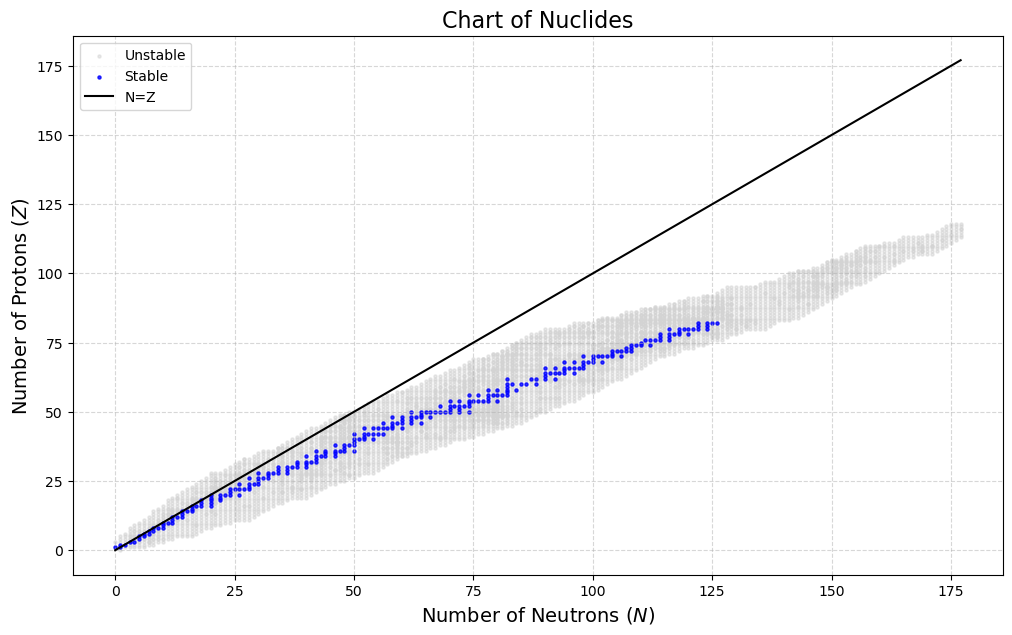

In [6]:
# Table of nucleides
plt.figure(figsize=(12, 7))

# Determination of unstable and unstable nuclei
unstables = df_nuclear[~df_nuclear['is_stable']]
stables = df_nuclear[df_nuclear['is_stable']]

# Same number of protons and neutrons
N0=df_nuclear['N'].min()
Nf=df_nuclear['N'].max()
y = np.linspace(N0, Nf,100)

# Scatter plot, s determines dot size
# Unstable 
plt.scatter(unstables['N'], unstables['Z'], c='lightgray', s=5, label='Unstable', alpha=0.5)
# Stable
plt.scatter(stables['N'], stables['Z'], c='blue', s=5, label='Stable', alpha=0.8)

# N=Z
plt.plot(y,y,c='black', linewidth=1.5, label='N=Z')

plt.xlabel('Number of Neutrons ($N$)', fontsize=14)
plt.ylabel('Number of Protons ($Z$)', fontsize=14)
plt.title('Chart of Nuclides', fontsize=16)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.savefig('../assets/chart_of_nuclides.png', dpi=300, bbox_inches='tight')
plt.show()

As shown in the chart, stable nuclei deviate from the $Z=N$ for $Z>20$ (approximately). This can be seen as a direct consequence of the **Coulomb repulsion** between charged particles, like protons:

<center>$F_c\propto \frac{Z(Z-1)}{A^{2/3}}$</center>

In contrast, the **nuclear force interaction** is much more poweful, but is a short-range force. It means its magnitude decays to 0 for larger distances, whereas the electromagnetic force has infinite range. 
For larger nuclei, the mass number $A$ increments, the short-range nuclear attraction saturares (only affecting neighboors) while the long-range Coulomb repulsion continues to grow across the entire volume of the nucleus. To compensate, stability is achieved by adding more neutrons, which provide attractive nuclear force without electric charge.

* Most stable nuclei are found in the range $1\leq N/Z \leq 1.5$

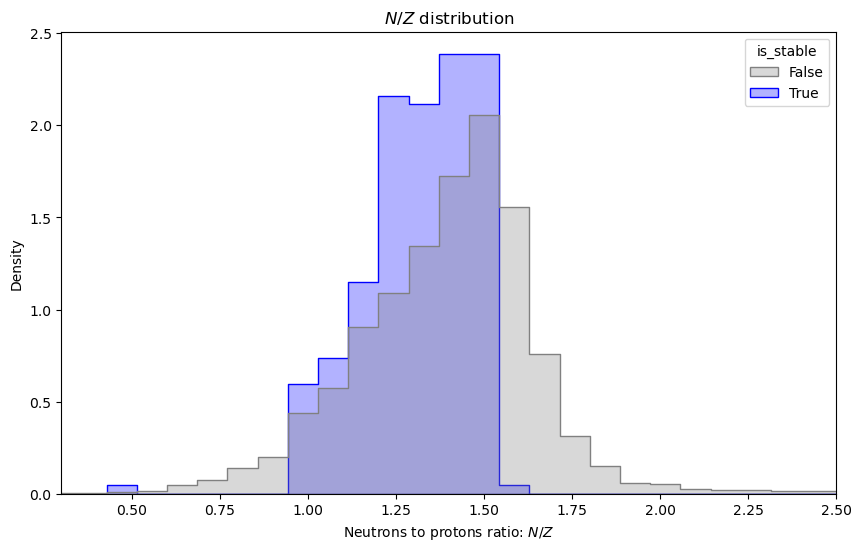

In [7]:
plt.figure(figsize=(10,6))

sns.histplot(data=df_nuclear, x='NZ_ratio', hue='is_stable',element="step", stat='density',
             common_norm=False, palette=['gray', 'blue'], bins=70, alpha=0.3)
plt.title('$N/Z$ distribution')
#plt.xlim(df['N'].min(),df['N'].max()) can't really visualize: 0 to 177
plt.xlim(0.3,2.5)
plt.xlabel('Neutrons to protons ratio: $N/Z$')
plt.show()

In addition to this, there are some interesting reasons why a nucleus is table or not. It is known that there are some highly stable configurations for the number of protons and neutrons in a nuclei, particularly, the numbers 2, 8, 20, 28, 50, 82 and 126 are called magic numbers precisely for this reason, and their stability lies on the nuclear shell model. Basically, the nucleons (protons and neutrons) are organized in shells, like electrons in atomic physics. When this shells are filled, or almost, the nucleus is more stable, and the magic numbers represent the amount of nucleons required to fullfill a shell. 

Based on the same mode, nuclear stability is strongly influenced by the pairing of nucleons and their angular momentum, like Cooper pairs in superconductivity. The dominant pairing is proton-proton and neutron-neutron, for this reason, one can see that even-even nuclei are more stable than odd-odd.

In [8]:
# Function to determine if a nucleus is even-even, odd-odd or even-odd
def get_pairing(row):
    if row['Z'] % 2 == 0 and row['N'] % 2 == 0:
        return 'Even-Even'
    elif row['Z'] % 2 != 0 and row['N'] % 2 != 0:
        return 'Odd-Odd'
    else:
        return 'Even-Odd'

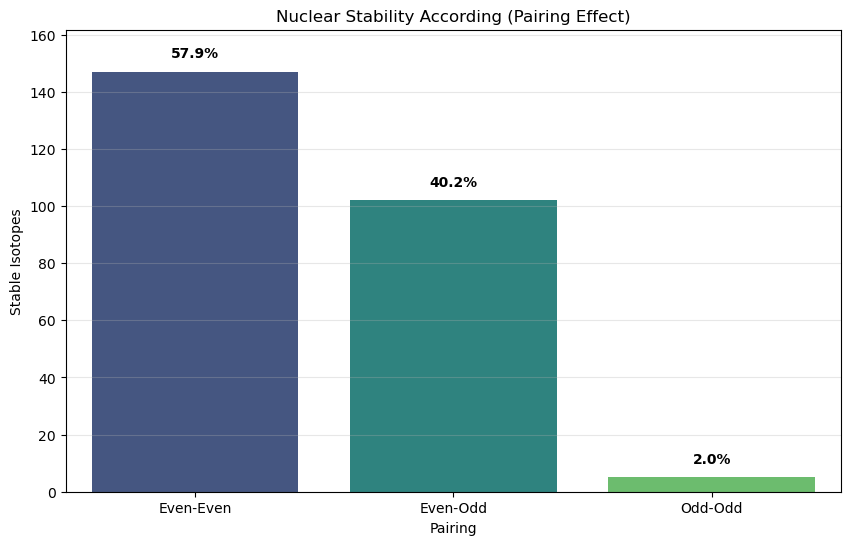

In [9]:
# Counting of even-even, odd-odd and even-odd
df_nuclear['Pairing'] = df_nuclear.apply(get_pairing, axis=1)
pairing_counts = df_nuclear[df_nuclear['is_stable'] == True]['Pairing'].value_counts()
total = pairing_counts.values.sum()
percentaje_EE_OO_EO = (pairing_counts.values / total) * 100

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=pairing_counts.index, 
            y=pairing_counts.values, 
            hue = pairing_counts.index, 
            palette='viridis', 
            legend=False)
plt.title('Nuclear Stability According (Pairing Effect)')
plt.ylabel('Stable Isotopes')
plt.grid(axis='y', alpha=0.3)
plt.ylim(0,max(pairing_counts.values)*1.1)

# Mostrar porcentajes encima de las barras (Opcional)
#for i, v in enumerate(percentaje_EE_OO_EO):
 #   plt.text(i, v + 5, str(v), ha='center', fontweight='bold')

for i, (h,p) in enumerate(zip(pairing_counts.values, percentaje_EE_OO_EO)):
    # ax.text(x, y, texto, alineación)
    ax.text(
        x = i, # Horizontal position
        y = h + 5, # Height + a litle offset
        s = f'{p:.1f}%', 
        ha ='center', 
        fontweight='bold')
    
plt.savefig('../assets/pairing_effect.png', dpi=300, bbox_inches='tight')
plt.show()

This effect is taken into acount through the numbers $Z$, $N$ and their Mass Excess ($\Delta(Z,N)$), which is related to the binding energy $BE(Z,N)$ in the form:

<center>
    \begin{align}
    \Delta(Z,N) & \equiv M(Z,N) - (Z+N)m_u\\
    & = \left[ZM_Z + NM_N - \frac{1}{c^2}BE(Z,N))\right] - (Z+N)m_u\\
    & = [Z(M_z-m_u) + N(M_N-m_u)] - \frac{BE(Z,N)}{c^2}
    \end{align}
</center>

Where $m_u$ is the atomic mass unit and $c$ the speed of light. It's clear how a larger binding energy leads to a more negative mass_excess. It's possible to express this mass in energy units multipliying by $c^2$ using $E=mc^2$, in this case, the mass excess is expressed in $keV$.

In [10]:
# Function for computing binding energy
def calculate_binding_energy_curve(df):
    """
    Compute Binding Energy per nucleon (BE/A)
    """
    # Delta(Neutron) = 8071.317 keV
    # Delta(Hydrogen-1) = 7288.970 keV, this includes electrons, in contrast with only protons
    DELTA_N_KEV = 8071.317
    DELTA_H_KEV = 7288.970
    
    # Adapted equation: BE = Z*DeltaH + N*DeltaN - MassExcess
    df['BE_total_keV'] = (df['Z'] * DELTA_H_KEV) + (df['N'] * DELTA_N_KEV) - df['Mass_Excess']
    
    # (BE/A)
    # np.where to avoid dividing by 0
    df['BE_per_A'] = np.where(df['A'] > 0, df['BE_total_keV'] / df['A'], 0)
    
    # Conversion to MeV for the plot, standard units
    df['BE_per_A_MeV'] = df['BE_per_A'] / 1000.0
    
    return df

df=calculate_binding_energy_curve(df_nuclear)

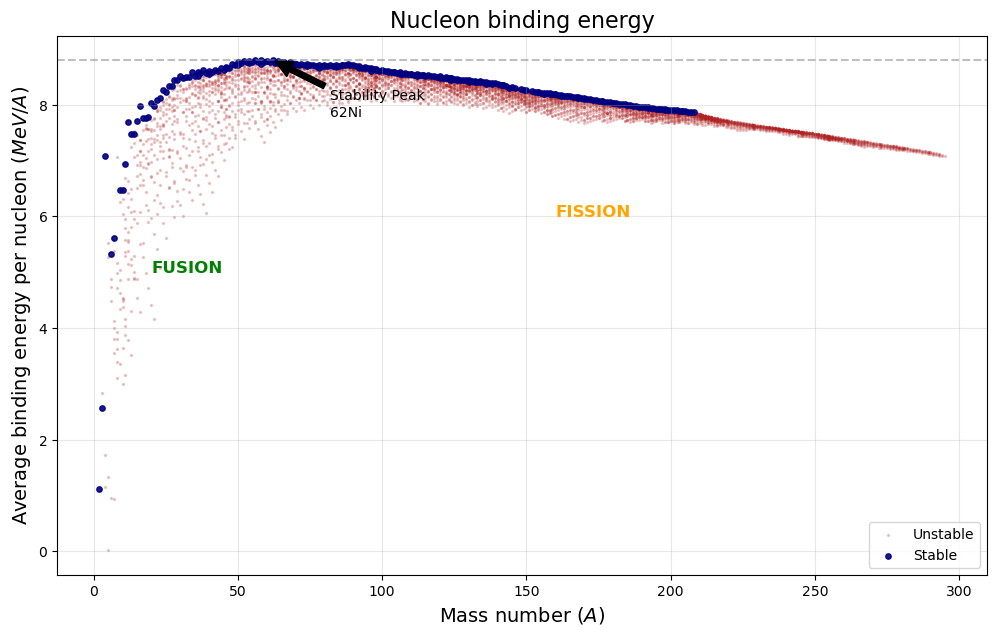

In [11]:
# Function for plotting binding energy
def plot_binding_energy(df):
    plt.figure(figsize=(12, 7))
    
    # Filter
    plot_data = df[(df['A'] > 0) & (df['BE_per_A_MeV'] > 0) & (df['BE_per_A_MeV'] < 10)].copy()

    # 1. Plot unstables 
    unstable = plot_data[plot_data['is_stable'] == 0]
    plt.scatter(unstable['A'], unstable['BE_per_A_MeV'], 
                c='firebrick', s=2, alpha=0.2, label='Unstable')

    # Plot stables
    stable = plot_data[plot_data['is_stable'] == 1]
    plt.scatter(stable['A'], stable['BE_per_A_MeV'], 
                c='navy', s=15, alpha=0.9, label='Stable')

    # Max value is either Fe-56 or Ni-62
    max_be = plot_data['BE_per_A_MeV'].max()
    max_nuclide = plot_data.loc[plot_data['BE_per_A_MeV'].idxmax()]
    
    plt.annotate(F"Stability Peak\n{max_nuclide['Element']}", 
                 xy=(max_nuclide['A'], max_be), 
                 xytext=(max_nuclide['A']+20, max_be-1),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    # Fusion and fision zones
    plt.text(20, 5, 'FUSION', fontsize=12, color='green', fontweight='bold')
    plt.text(160, 6, 'FISSION', fontsize=12, color='orange', fontweight='bold')

    # Estética
    plt.title('Nucleon binding energy', fontsize=16)
    plt.xlabel('Mass number ($A$)', fontsize=14)
    plt.ylabel('Average binding energy per nucleon ($MeV/A$)', fontsize=14)
    plt.axhline(y=max_be, color='gray', linestyle='--', alpha=0.5)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.savefig('../assets/binding_energy.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_binding_energy(df)

The plot shows how for the same $A$, the stables nuclei lie on the top of the curve, in the zone with a higher average binding energy per nucleon, ramarking the mass excess importance while determining whether a nucleus is table or not.

The curve reaches its maximum at Nickel-62, this is the most energetically favorable state for nuclear matter. From this point one can identify two zones: Fusion and fision, on the left and right size (respectively) of the stability peak. 

* **Fusion zone:** The slope on the left side (low A) is very steep, indicating that small nuclei are relatively loosely bound. When two light nuclei (like Deuterium and Tritium) combine to form a heavier nucleus (like Helium-4) they move up the curve. The final nucleus is much more tightly bound than the initial ones, this tightening results in a loss of mass, that according to Einstein equation $E=mc^2$ is converted into a massive amount of kinetic energy.
*  **Fission zone:** The slope on the right side (high A) declines gradually. When a heavy nucleus (like Uranium-235) splits into two smaller fragments, the new nuclei fall closer to the middle of the chart. Therefore, by splitting these fragments move up the curve, they become more stable than the original parent and the difference in binding energy between the heavy uranium and the medium fragments is released as heat and radiation. 